In [ ]:
from ultralytics import YOLO
import cv2
import math
import matplotlib.pyplot as plt
import pytesseract
import easyocr
import numpy as np

In [ ]:
# Cargar modelo
model = YOLO('yolov8n.yaml') # Construir nuevo modelo desde yaml

#results = model.train(data='spanish_license_plates_dataset/data.yaml', epochs=50, imgsz=640)


In [19]:
def read_license_plate(license_plate_crop):
    #Carga del modelo de lengua
    reader = easyocr.Reader(['en'], gpu=False) 

    plt.axis("off")
    plt.imshow(license_plate_crop) 
    plt.show()

    #Reconocimiento de una imagen
    total_license = ""
    results = reader.readtext(license_plate_crop, min_size=120)
    for result in results:
        bbox, text, score = result
        text = text.upper().replace(' ', '')
        total_license += text
    print(total_license)




Using CPU. Note: This module is much faster with a GPU.


Confidence ---> 0.8
Class name --> matricula


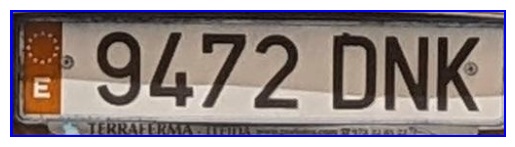

0: 384x640 1 plate, 128.7ms
Speed: 8.0ms preprocess, 128.7ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)


9472DNK


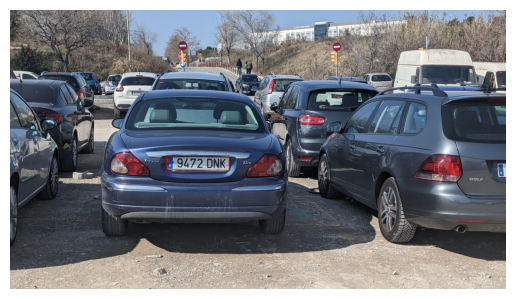

In [23]:
bestModel = YOLO('runs/detect/train6/weights/best.pt')
classNames = ['matricula'] 

image_path = 'media/imagetest6.jpg'
img = cv2.imread(image_path)


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = bestModel(img, stream=True)

for r in results:
    boxes = r.boxes

    for box in boxes:
        # Contenedor
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
        
        # Confianza
        confidence = math.ceil((box.conf[0]*100))/100
        print("Confidence --->",confidence)           

        # Clase
        cls = int(box.cls[0])
        print("Class name -->", classNames[cls])

        # Convierte identificador numérico de clase a un color RGB
        escala = int((cls / len(classNames)) * 255 * 3)
        if escala >= 255*2:
            R = 255
            G = 255
            B = escala - 255*2
        else:
            if escala >= 255:
                R = 255
                G = escala - 255
                B = 0
            else:
                R = escala
                G = 0
                B = 0

        # Dibuja el contenedor y clase
        cv2.rectangle(img, (x1-10, y1-10), (x2+10, y2+10), (0, 0, 255), 4)
        cv2.putText(img, classNames[cls] , [x1 -10, y1 -10], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, B), 1)

        license_plate_crop = img[y1 - 10:y2 + 10, x1 - 10:x2 + 10]
        license_plate_crop_resized = cv2.resize(license_plate_crop, (250, 150))
        license_plate_crop_gray = cv2.cvtColor(license_plate_crop_resized, cv2.COLOR_BGR2GRAY)

        license_plate_crop_thresh = cv2.adaptiveThreshold(license_plate_crop_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
        read_license_plate(license_plate_crop)

plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
plt.show()







In [ ]:
bestModel = YOLO('runs/detect/train6/weights/best.pt')
classNames = ['matricula']

cap = cv2.VideoCapture('media/prueba.mp4')  
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    results = bestModel(frame, stream=True)

    for r in results:
        boxes = r.boxes

        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            cv2.rectangle(frame, (x1 - 10, y1 - 10), (x2 + 10, y2 + 10), (0, 0, 255), 4)

    cv2.imshow('Video', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam
cap.release()
cv2.destroyAllWindows()